# Recostruction post PCA

### importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
import os
from os import listdir




In [2]:
dim = 1544
#373, 90, 20, 1544

In [3]:
base_dir = os.getcwd()

In [4]:
data_dir = os.path.join(base_dir, 'data')
output_dir = os.path.join(base_dir, 'outputs')
processed_data_dir = os.path.join(base_dir, 'processed_data')
file_path = os.path.join(processed_data_dir, 'data_pca_' + str(dim) + '.pth')
files = listdir(data_dir)

# numero file presenti
print(len(files))

280


### Useful Functions and classes

In [5]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if "target" in self.states.columns.values:
            target = int(self.states.target.values[idx])
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}
    

def my_transform(key="train"):
    train_sequence = [transforms.Resize((50,50)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip(),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    
    val_sequence = [transforms.Resize((50,50)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        
    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

## Importing Data

In [6]:
train_file_path = os.path.join(processed_data_dir, 'train_df.pkl')
test_file_path =  os.path.join(processed_data_dir, 'test_df.pkl')
dev_file_path =  os.path.join(processed_data_dir, 'dev_df.pkl')

In [7]:
train_df = pd.read_pickle(train_file_path)
test_df = pd.read_pickle(test_file_path)
dev_df = pd.read_pickle(dev_file_path)

In [8]:
train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))   

In [9]:
batch_size=7500
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [10]:
dataloaders = {"train": train_loader, "dev": dev_loader, "test": test_loader}
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

5 5 7


## Normalization

Minimo valore di pixel: -2.032280206680298
Massimo valore di pixel: 2.640000104904175


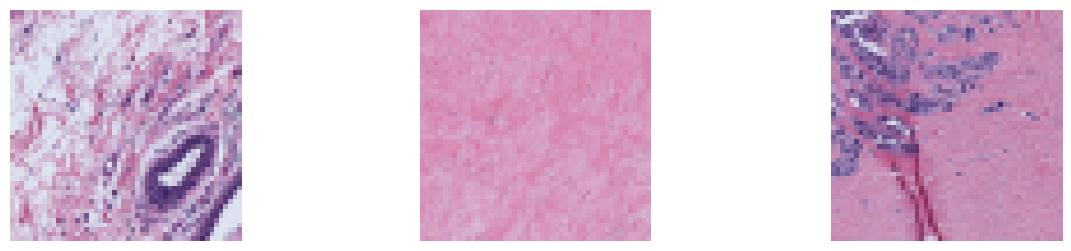

In [11]:
batch = next(iter(train_loader))

batch_images = batch["image"]

min_value = np.min(batch_images.numpy())
max_value = np.max(batch_images.numpy())

print(f"Minimo valore di pixel: {min_value}")
print(f"Massimo valore di pixel: {max_value}")

normalized_images = (batch_images - min_value) / (max_value - min_value)

normalized_images = np.clip(normalized_images, 0, 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i in range(3):
    image = normalized_images[i].permute(1, 2, 0)  
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

In [12]:
num_samples = normalized_images.shape[0]
num_channels = normalized_images.shape[1]
height = normalized_images.shape[2]
width = normalized_images.shape[3]

flattened_images = normalized_images.reshape(num_samples, -1)

## PCA

In [13]:
num_features = normalized_images.shape[1]
pca = PCA(dim)


pca.fit(flattened_images)

pca_images = pca.transform(flattened_images)
reconstructed_images = pca.inverse_transform(pca_images)


explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)


# Reconstructing images after PCA

In [14]:
reconstructed_images = reconstructed_images.reshape(num_samples, num_channels, height, width)

min_value = np.min(reconstructed_images)
max_value = np.max(reconstructed_images)

print(f"Minimo valore di pixel: {min_value}")
print(f"Massimo valore di pixel: {max_value}")

reconstructed_images = reconstructed_images * (max_value - min_value) + min_value

reconstructed_images = np.clip(reconstructed_images, 0, 1)


Minimo valore di pixel: -0.14487448793120283
Massimo valore di pixel: 1.0769685484390932


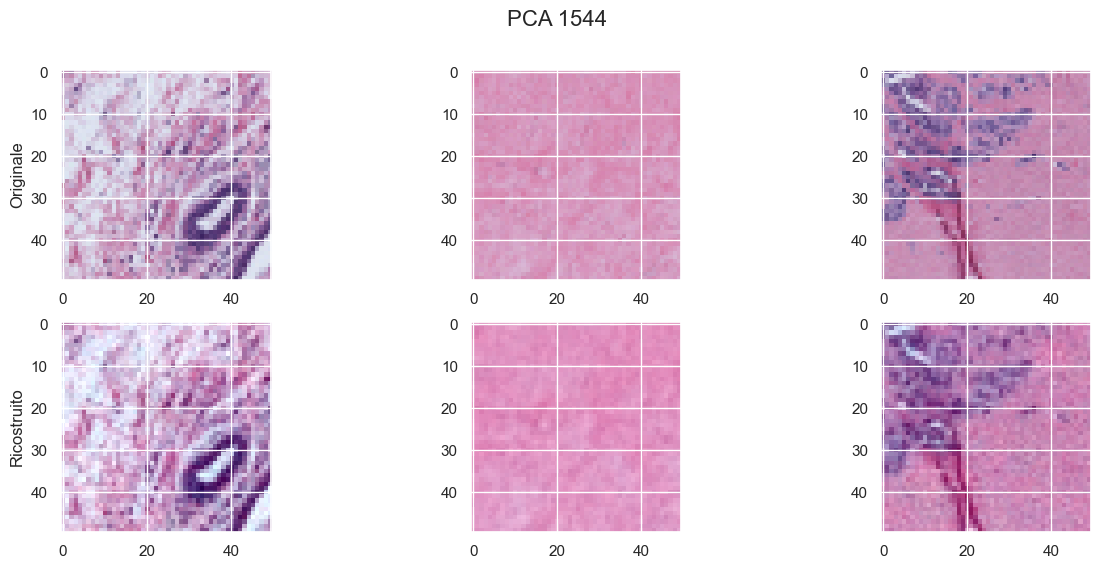

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for i in range(3):

    original_image = normalized_images[i].permute(1, 2, 0)  # Cambia le dimensioni del tensore da (C, H, W) a (H, W, C) per matplotlib
    axes[0, i].imshow(original_image)

    reconstructed_image = np.transpose(reconstructed_images[i], (1, 2, 0))
    axes[1, i].imshow(reconstructed_image)

axes[0, 0].set_ylabel('Originale')
axes[1, 0].set_ylabel('Ricostruito')
title = 'PCA '+ str(dim)+''
fig.suptitle(title, fontsize=16)
fig.savefig(os.path.join(output_dir, title+'.png'))
plt.show()
